## Importation des bibliothèques nécessaires

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

## Importation et pré-traitement des données 

### Importation et premières informations

In [2]:
data = pd.read_csv("accident.csv")
print(data.info())
data["Survived"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB
None


Survived
1    101
0     99
Name: count, dtype: int64

In [3]:
data.isna().sum()

Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64

On a un équilibre entre le nombre de survivants et le nombre de morts dans les données, ce qui est positif pour l'analyse et les modèles à suivre. 

On a trois variables (Gender, Helmet_Used et Seatbelt_Used) de type 'object', qui ne nous permettent pas de créer correctement nos modèles. Il faudra donc les transformer en variables 'int64' en remplaçant les noms de classes par des entiers (0 - 1). 

Enfin, on peut distinguer une valeur manquante dans le genre et 3 valeurs manquantes dans la vitesse de collision. Il faudra alors traiter ces valeurs manquantes pour pouvoir entrainer nos modèles. 

In [4]:
# Suppression des observations contenant des valeurs manquantes
data = data.dropna()

#Remplacement des noms des groupes par 0 ou 1
data = data.replace({ 'No': 0, 'Yes': 1})
data = data.replace({ 'Female': 0, 'Male': 1})

# Recalcul de l'équilibre dans la colonne d'intérêt après la suppression
data["Survived"].value_counts()

Survived
1    100
0     96
Name: count, dtype: int64

Les données manquantes étant peu nombreuses, nous n'imputerons pas nos valeurs manquantes, risquant d'altérer nos modèles. On va donc simplement supprimer les observations contenant des valeurs manquantes. On peut voir que l'équilibre entre les survivants et les morts a été légèrement modifié, mais il reste globalement satisfaisant. 

### Analyse de la corrélation entre les variables

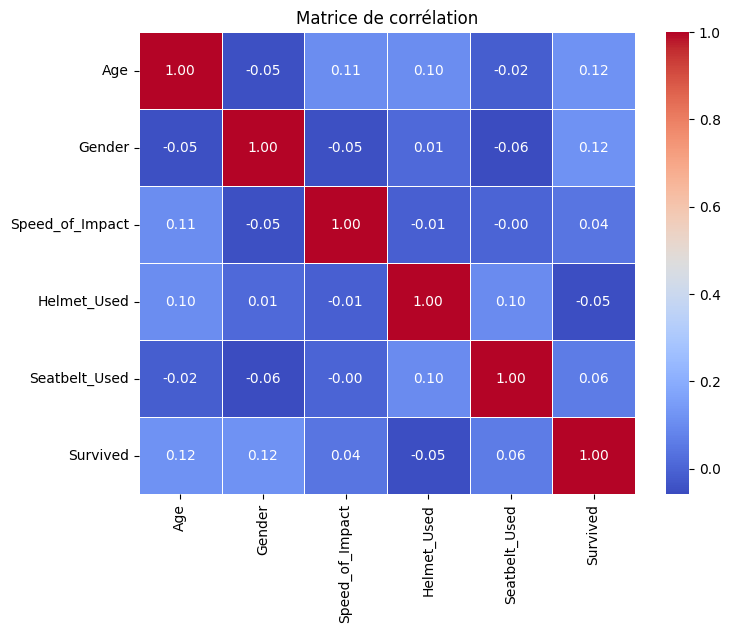

La corrélation absolue maximale des colonnes est :0.11921252449839063


In [5]:
corr = data.corr()
plt.figure(figsize=(8, 6))
sbn.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Matrice de corrélation")
plt.show()

print(f"La corrélation absolue maximale des colonnes est :{abs(corr[corr < 1].max().max())}")

La corrélation maximale obtenue est très faible démontrant qu'on a uniquement des variables qui sont globalement décorrélées, ce qui est le mieux pour nous modèles. 

## Premiers modèles

#### Séparation des données en train / test 

In [6]:
y = data["Survived"]
x = data.drop("Survived", axis=1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=42)

On veut prédire la survie ou non des individus, alors notre résultat y est la colonne "Survived" du data Frame. On la retire donc de notre dataFrame pour en faire l'ensemble des variables x. 

On fait ensuite un split permettant d'apprendre sur 80% de nos données et de tester nos modèles sur 20% de nos données. 

#### Arbre de décision

L'arbre de décision est le modèle supervisé qui vient le plus naturellement de part sa simplicité et son interprétation plutôt simple.

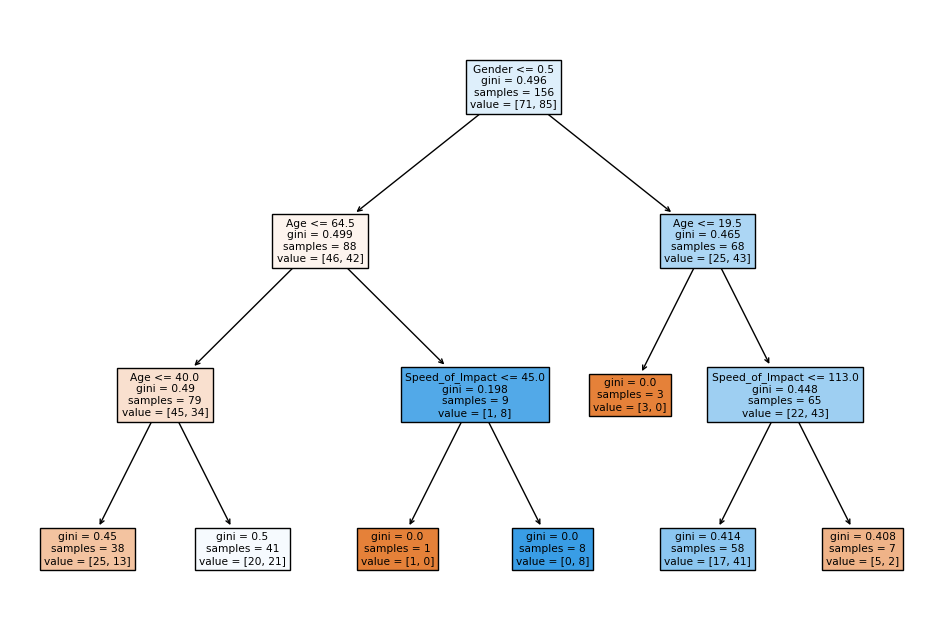

Le pourcentage de bien classés est de : 47.5 %
Le Recall est de : 0.8
La Precision est de : 0.4
Le F-0.5-score est de : 0.4444444444444445


,Dead_predit,Survived_predit
Dead_données,7,18
Survived_données,3,12


In [7]:
# Entrainement du modèle
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X = x_train, y = y_train)

# Affichage de l'arbre de décision
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names= x.columns, filled=True)
plt.show()

#Evaluation du modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, clf.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, clf.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, clf.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, clf.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, clf.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])

Après plusieurs tests pour différentes profondeurs maximales, la profondeur 5 donne le meilleur résultat en pourcentage de bien classés (55%). L'incovénient avec une profondeur au-delà de 3 est l'illisibilité du graphique qui est difficilement interprétable. En revanche en s'arrêtant à la profondeur 3, on obtient sensiblement le meilleur F.-0.5-score (0,444 contre 0.439).  

Ce qui serait le plus interéssant c'est d'avoir une bonne précision, permettant de prédire le moins possible la survie à tort. Un faux positif peut s'avérer grave pour un test d'aptitude de survie. Il est également judicieux d'avoir un bon rappel ( la capacité à capter tous les survivants) mais cette métrique est un peu moins importante que la première. Alors on va se fier à un test F-Beta avec Beta = 0.5, donnant un poids plus important à la précision. 

On constate que le modèle est peu satisfaisant, et qu'il faudra tester d'autres modèles. 

#### Forêt aléatoire 

La forêt aléatoire est une combinaison d'arbres, qui devrait donner en théorie un résultat au moins aussi satisfaisant qu'un arbre de décision, si ce n'est un meilleur. 

In [8]:
# Entrainement de plusieurs modèles avec la même profondeur max et selection du meilleur F-0.5-score

model_rf = None
best_fbeta = -np.inf 

    # Boucle pour entraîner 5 fois le modèle
for i in range(5):
    test_rf = RandomForestClassifier( n_estimators=100, max_depth=2, random_state=i)  # Changer le random_state à chaque fois
    test_rf.fit(x_train, y_train)
 
    # Calcul du F-0.5-score
    fbeta = fbeta_score(y_test, test_rf.predict(x_test), beta=0.5)
    
    # Vérifier si ce modèle est le meilleur
    if fbeta > best_fbeta:
        best_fbeta = fbeta
        model_rf = test_rf

# Evaluation du meilleur modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_rf.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, model_rf.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, model_rf.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, model_rf.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, model_rf.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])

Le pourcentage de bien classés est de : 50.0 %
Le Recall est de : 0.8666666666666667
La Precision est de : 0.41935483870967744
Le F-0.5-score est de : 0.4676258992805755


,Dead_predit,Survived_predit
Dead_données,7,18
Survived_données,2,13


Après plusieurs tests, on a pu apercevoir que pour une même profondeur maximale, on avait des scores assez différents à chaque fois qu'on faisait tourner le code. En faisant 5 entrainements pour selectionner le meilleur modèle, on assure d'avoir une valeur similaire à chaque fois pour la même profondeur maximale.

En testant plusieurs profondeurs différentes, La profondeur 2 donne le meilleur F-0.5-score. Bien que le pourcentage de bien classés (50%) soit moins bon que celui de l'arbre profondeur 5 (55%) ( mais meilleur que celui de l'arvre profondeur 3), le F-0.5-score (0.47) est légèrement meilleur que celui des arbres profondeur 3 et 5 (autour de 0.44).

Le modèle ne donne toujours pas satisfaction mais il améliore nos résultats selon nos critères. 


#### Réseau de neurones MLP

Le réseau de neurones est une des solutions à tester après la forêt aléatoire, qui apporte souvent satisfaction. Son paramétrage nécessite parfois un nombre important de tests pour avoir la meilleure combinaision de couches. 

In [9]:
# Entrainement du modèle
model_mlp = MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200, 200, 100), max_iter=10000, random_state=42, activation='relu')
model_mlp.fit(x_train, y_train)

# Évaluation du modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_mlp.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, model_mlp.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, model_mlp.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, model_mlp.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, model_mlp.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])

Le pourcentage de bien classés est de : 65.0 %
Le Recall est de : 0.3333333333333333
La Precision est de : 0.5555555555555556
Le F-0.5-score est de : 0.49019607843137253


,Dead_predit,Survived_predit
Dead_données,21,4
Survived_données,10,5


Après plusieurs tests, la meilleure combinaison de couches apporte un résulat meilleur que la forêt aléatoire. En effet On améliore toutes les métriques, sauf le rappel qui chute (moins de la moitié du rappel de la forêt). On a pour la première fois une précision au delà de 0.5 et un F-0.5-score qui est à 0.49, encore meilleur que celui de l'arbre. 

On a donc encore amélioré nos résultats, sans pour autant pouvoir en tirer satisfaction. Explorons donc autrement notre dataset. 

## Premier travail sur le dataset

Dans notre dataset, il n'y a que deux variables qui ne sont pas sous forme de groupes : l'age et la vitesse. Un premier travail possible sur notre dataset est donc de découper en groupe ces variables afin d'essayer de faciliter l'apprentissage pour nos modèles.

#### Découpage en groupe des deux variables

In [10]:
# Copie de notre dataset dans une nouvelle variable
data_class = data.copy()

#Découpage de l'age en trois groupes
tercile_age = data["Age"].quantile([1/3, 2/3])
conditions = [(data_class["Age"] < tercile_age[1/3]), (data_class["Age"] < tercile_age[2/3])]
values = [0, 1]
data_class.insert(0, 'AgeGroup', np.select(conditions, values, default=2))
data_class = data_class.drop('Age', axis=1)

#Découpage de la vitesse en trois groupes
tercile_speed = data["Speed_of_Impact"].quantile([1/3, 2/3])
conditions = [(data_class["Speed_of_Impact"] < tercile_speed[1/3]), (data_class["Speed_of_Impact"] < tercile_speed[2/3])]
values = [0, 1]
data_class.insert(2, 'SpeedLevel', np.select(conditions, values, default=2))
data_class = data_class.drop('Speed_of_Impact', axis=1)

Le nombre de groupes choisis (3) est aléatoire. On avait dans l'idée que 2 ce n'était pas assez et 4 ce serait peut-être trop. 

On découpe l'age en trois groupes :
- 0 : Jeune (< 35)
- 1 : Median (< 52)
- 2 : Senior (> 52)

On découpe la vitesse en trois groupes :
- 0 : vitesse relativement basse (< 51)
- 1 : vitesse relativement moyenne (< 84)
- 2 : vitesse relativement haute (> 84)

Les deux découpages ont été fait en fonction des terciles pour avoir des groupes plutôt équilibrés. 

#### Nouvelle séparation des données

In [11]:
y = data_class["Survived"]
x = data_class.drop("Survived", axis=1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=42)

On va donc entrainer à nouveau nos trois modèles et constater si le regroupement permet ou non une amélioration des résultats. 

#### Arbre de décision

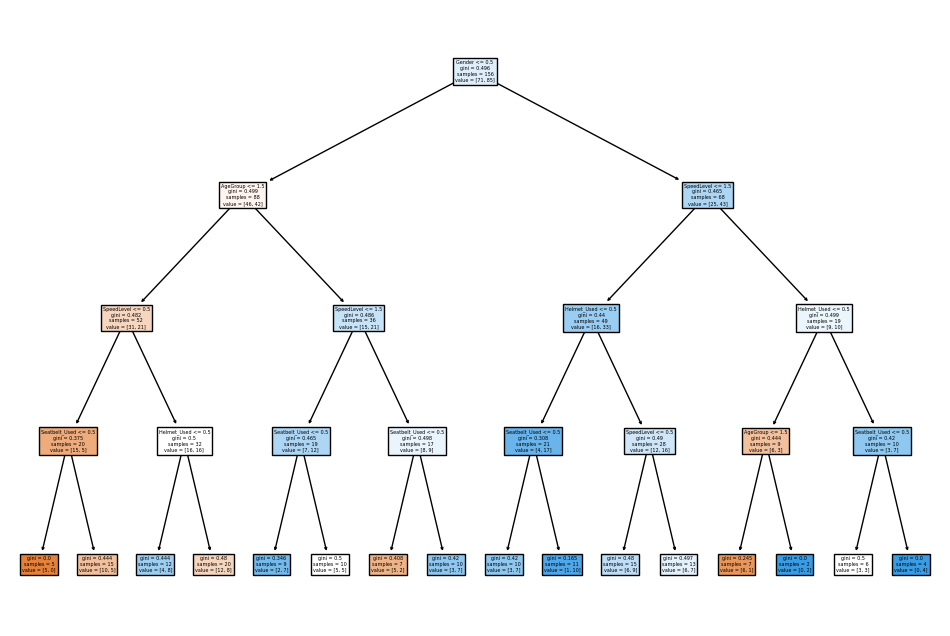

Le pourcentage de bien classés est de : 50.0 %
Le Recall est de : 0.7333333333333333
La Precision est de : 0.4074074074074074
Le F-0.5-score est de : 0.4471544715447154


,Dead_predit,Survived_predit
Dead_données,9,16
Survived_données,4,11


In [12]:
# Entrainement du modèle
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X = x_train, y = y_train)

# Affichage de l'arbre de décision
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names= x.columns, filled=True)
plt.show()

#Evaluation du modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, clf.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, clf.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, clf.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, clf.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, clf.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])

Après plusieurs tests, on obtient le meilleur F-0.5-score (0.48) avec un arbre profondeur 4 et une exactitude de 50%. On a donc améloré le résultat de l'arbre aléatoire sur notre dataset. 

#### Forêt Aléatoire

In [13]:
# Entrainement de plusieurs modèles avec la même profondeur max et selection du meilleur F-0.5-score

model_rf = None
best_fbeta = -np.inf 

    # Boucle pour entraîner 5 fois le modèle
for i in range(5):
    test_rf = RandomForestClassifier( n_estimators=100, max_depth=4, random_state=i)  # Changer le random_state à chaque fois
    test_rf.fit(x_train, y_train)
 
    # Calcul du F-0.5-score
    fbeta = fbeta_score(y_test, test_rf.predict(x_test), beta=0.5)
    
    # Vérifier si ce modèle est le meilleur
    if fbeta > best_fbeta:
        best_fbeta = fbeta
        model_rf = test_rf

# Evaluation du meilleur modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_rf.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, model_rf.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, model_rf.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, model_rf.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, model_rf.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])

Le pourcentage de bien classés est de : 55.00000000000001 %
Le Recall est de : 0.9333333333333333
La Precision est de : 0.45161290322580644
Le F-0.5-score est de : 0.5035971223021583


,Dead_predit,Survived_predit
Dead_données,8,17
Survived_données,1,14


Après plusieurs tests, le meilleur résultat obtenu est un F-0.5-score de 0.50 avec une exactitude de 55%. C'est un meilleur résultat que la première forêt aléatoire qui avait un F-0.5-score de 0.47 et une exactitude de 50%. 

#### Réseau de neurones MLP

In [14]:
model_mlp = MLPClassifier(hidden_layer_sizes=(201, 179), max_iter=1000, random_state=42, activation='relu')
model_mlp.fit(x_train, y_train)

# Évaluation de l'efficacité du modèle

print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_mlp.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, model_mlp.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, model_mlp.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, model_mlp.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, model_mlp.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])


Le pourcentage de bien classés est de : 50.0 %
Le Recall est de : 0.7333333333333333
La Precision est de : 0.4074074074074074
Le F-0.5-score est de : 0.4471544715447154


,Dead_predit,Survived_predit
Dead_données,9,16
Survived_données,4,11


Après plusieurs tests, on n'a pas réussi à obtenir une combinaison de couches donnant un résultat au moins égal à celui du premier réseau de neurones. Le mieux qu'on ait pu avoir est un F-0.5-score de 0.45, en deçà des autres modèles. 

Il faudra alors explorer d'autres solutions pour avoir un résultat satisfaisant. 

## Deuxième travail sur le dataset 

Le deuxième travail sur le dataset porte sur les données des dispositifs de sécurité (Helmet_Used et Seatbelt_Used). L'existence de ces deux colonnes peut porter à confusion car il n'y a pas de ceintures de sécurité à moto et pas de casques en voiture en théorie. là encore, c'est un peu irréalise de voir que certains individus ont les deux dispositifs dans le dataset. 

C'est pourquoi on a pris la décision (arbitraire) de regrouper ces deux colonnes, permettant de savoir si au moins un dispositif de sécurité a été utilisé, quel qu'il soit. On lève donc l'ambiguité et ca pourrait faciliter l'apprentissage des modèles. 

#### Regroupement des deux variables

In [15]:
# Création d'une nouvelle variable qui regroupe les dispositifs
data_class.insert(3, "SafetyDevice_Used", (data_class["Helmet_Used"] + data_class["Seatbelt_Used"]).clip(0, 1))

# Suppression des deux variables 
data_class = data_class.drop(["Helmet_Used", "Seatbelt_Used"], axis=1)

#### Séparation des données

In [16]:
y = data_class["Survived"]
x = data_class.drop("Survived", axis=1)
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=42)

On sépare à nouveau notre dataset et on entraine nos modèles 

#### Arbre de décision

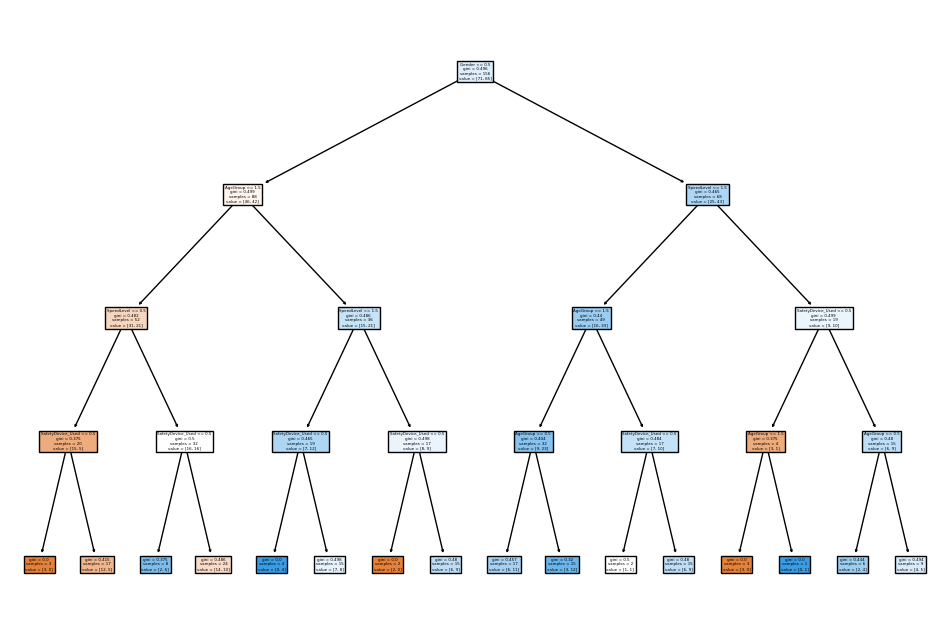

Le pourcentage de bien classés est de : 45.0 %
Le Recall est de : 0.6666666666666666
La Precision est de : 0.37037037037037035
Le F-0.5-score est de : 0.40650406504065034


,Dead_predit,Survived_predit
Dead_données,8,17
Survived_données,5,10


In [34]:
# Entrainement du modèle
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X = x_train, y = y_train)

# Affichage de l'arbre de décision
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names= x.columns, filled=True)
plt.show()

#Evaluation du modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, clf.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, clf.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, clf.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, clf.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, clf.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])

#### Forêt Aléatoire

In [22]:
# Entrainement de plusieurs modèles avec la même profondeur max et selection du meilleur F-0.5-score

model_rf = None
best_fbeta = -np.inf 

    # Boucle pour entraîner 5 fois le modèle
for i in range(5):
    test_rf = RandomForestClassifier( n_estimators=300, max_depth=4, random_state=i)  # Changer le random_state à chaque fois
    test_rf.fit(x_train, y_train)
 
    # Calcul du F-0.5-score
    fbeta = fbeta_score(y_test, test_rf.predict(x_test), beta=0.5)
    
    # Vérifier si ce modèle est le meilleur
    if fbeta > best_fbeta:
        best_fbeta = fbeta
        model_rf = test_rf

# Evaluation du meilleur modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_rf.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, model_rf.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, model_rf.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, model_rf.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, model_rf.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])

Le pourcentage de bien classés est de : 42.5 %
Le Recall est de : 0.6666666666666666
La Precision est de : 0.35714285714285715
Le F-0.5-score est de : 0.3937007874015748


,Dead_predit,Survived_predit
Dead_données,7,18
Survived_données,5,10


#### Réseau de neurones MLP

In [33]:
model_mlp = MLPClassifier(hidden_layer_sizes=(7, 257, 107), max_iter=1000, random_state=42, activation='relu')
model_mlp.fit(x_train, y_train)

# Évaluation de l'efficacité du modèle

print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_mlp.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, model_mlp.predict(x_test))}")
print(f"La Precision est de : {precision_score(y_test, model_mlp.predict(x_test))}")
print(f"Le F-0.5-score est de : {fbeta_score(y_test, model_mlp.predict(x_test), beta=0.5)}")
pd.DataFrame(confusion_matrix(y_test, model_mlp.predict(x_test)),
             index = ["Dead_données", "Survived_données"],
             columns = ["Dead_predit", "Survived_predit"])


Le pourcentage de bien classés est de : 47.5 %
Le Recall est de : 0.4
La Precision est de : 0.3333333333333333
Le F-0.5-score est de : 0.3448275862068965


,Dead_predit,Survived_predit
Dead_données,13,12
Survived_données,9,6


Les résultats n'ont pas été amélioré par cette idée. 

Plusieurs commentaires Kaggle ont obtenu des résultats identiques avec d'autres méthodes, montrant alors que le dataset manque de variables ou d'observations permettant d'obtenir de meilleurs modèles. On pourrait par exemple ajouter le type de véhicule conduit et/ou percuté, l'ancienneté du permis de conduire, le temps de prise en charge ou encore les tests d'alcoolémie ou stupéfiants. 